# Processing HCC TMA 1 Images for QuPath Project Reading and Analysis
Cole Nawrocki

In [1]:
# Data handling
import numpy as np
import pandas as pd
import dask
import dask.array as da

# OS interactions
import os
import glob

# Imaging
import tifffile
import skimage as sk

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# All the file names for the stains. Make sure that they are sorted!
filenames = glob.glob("/Users/ccn22/Library/CloudStorage/OneDrive-MassGeneralBrigham/cosmx/franses-hcc-data/hcc_tma1/Morphology2D"+"/*.TIF")
filenames.sort()

# Dask alters the image reading function to be "delayed"
lazy_arrays = [dask.delayed(sk.io.imread)(fn) for fn in filenames]

# "Reading" the images into a list of dask arrays
# We know that each image is 4256 by 4256 pixels for 5 channels and is 16-bit
lazy_arrays = [da.from_delayed(x, shape=(5, 4256, 4256), dtype="uint16") for x in lazy_arrays]

In [3]:
# Showing the data
dd = da.stack(lazy_arrays, axis=1)
dd

dask.array<stack, shape=(5, 80, 4256, 4256), dtype=uint16, chunksize=(5, 1, 4256, 4256), chunktype=numpy.ndarray>

In [4]:
# Writing a helper function that we can apply to each chunk, or image
def bit8_conversion(bit16_block):
    bit8_block = bit16_block.copy()
    for i in range(5):
        bit8_block[i,...] = (bit8_block[i,...]/bit8_block[i,...].max())*255
    return bit8_block

In [10]:
# Converting to 8-bit
dd_8b = []
for i in range(dd.shape[1]):
    dd_8b.append(bit8_conversion(dd[:,i,:,:]))

In [11]:
dd_8b = da.stack(dd_8b, axis=1)
dd_8b = dd_8b.astype("uint8")

In [12]:
dd_8b

dask.array<astype, shape=(5, 80, 4256, 4256), dtype=uint8, chunksize=(5, 1, 4256, 4256), chunktype=numpy.ndarray>

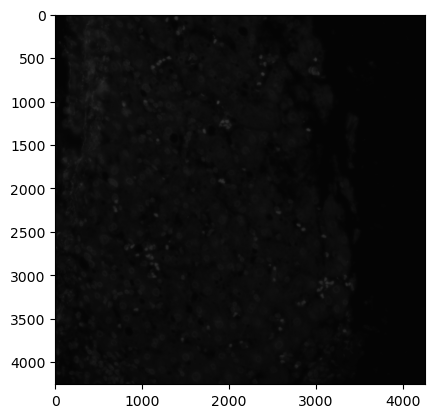

In [14]:
plt.imshow(dd_8b[4, 21,...], cmap = "grey")

In [17]:
# Writing each DAPI stain as tiff
outs = "/Users/ccn22/Library/CloudStorage/OneDrive-MassGeneralBrigham/cosmx/franses-hcc-data/hcc_tma1/8bit_IF_images/"
for i in range(dd.shape[1]):
    tifffile.imwrite(f"{outs}FOV{str(i+1).zfill(3)}.TIF", dd_8b[:,i,:,:], ome=True, imagej=True)